In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/gesture_data.csv


In [2]:
import ast

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Custom converters for array columns
array_converters = {'x': str_to_list, 'y': str_to_list, 'z': str_to_list}

# Read training data
training_data = pd.read_csv("./data/gesture_data.csv", 
                            converters=array_converters)

# Verify the changes
print("Training data 'x' column first row:")
print(training_data.loc[0, 'x'])
print("\nType of 'x' column first row:")
print(type(training_data.loc[0, 'x']))

Training data 'x' column first row:
[-1.25576014503751, -1.370739782544951, -1.9839655997993495, -1.3324131533336467, 0.2006510146126411, 0.9288567195009527, 0.4306107898804676, -0.02930851052871322, -0.3742481734304529, 0.31563090224655427, 1.925348328615451, 1.5804089158401833, 0.4306107898804676, 0.12399775619003224, 0.23897764382394554, -0.02930851052871322, 0.2006510146126411]

Type of 'x' column first row:
<class 'list'>


In [3]:
# checking how many data points per axes
mydict = {'x': [9999,0],
          'y': [9999,0],
          'z': [9999,0]}
for i in range(len(training_data)):
    for axes, hidden in mydict.items():
        if len(training_data.loc[i, axes]) < hidden[0]:
            mydict[axes][0] = len(training_data.loc[i, axes])
        if len(training_data.loc[i, axes]) > hidden[1]:
            mydict[axes][1] = len(training_data.loc[i, axes])

print(mydict)

{'x': [10, 51], 'y': [10, 51], 'z': [10, 51]}


In [4]:
print(training_data.head())

   id  user  gesture                                                  x  \
0   0     3       16  [-1.25576014503751, -1.370739782544951, -1.983...   
1   1     0       16  [-1.448612587493181, -1.54418083750065, -2.149...   
2   2     5        2  [1.371997640260515, 1.4641467904789716, 1.4027...   
3   3     4        8  [1.2042132629209805, 1.3117093394113715, 1.365...   
4   4     5        6  [0.2735127432113492, 0.30908169307960875, 0.16...   

                                                   y  \
0  [0.5405893101919109, 0.6131419581073716, -0.11...   
1  [0.5531080695207085, 0.6374051435375361, 0.272...   
2  [-1.8916694746227074, -1.808671134024168, -1.6...   
3  [-1.0692992132913253, -1.1232782922952929, -0....   
4  [0.13146940063485005, 0.16520937818051507, 0.1...   

                                                   z  
0  [-0.11737058698735427, 0.08215949770223907, 0....  
1  [-0.8150173543894822, -0.8777110334773569, -0....  
2  [0.8736550920453047, 0.8736550920453047, 0.8

In [5]:
# Function to pad or truncate the array
def pad_or_truncate(array, target_length=40):
    if len(array) > target_length:
        return array[:target_length]
    elif len(array) < target_length:
        return array + [0] * (target_length - len(array))
    else:
        return array

for col in ["x","y","z"]:
    training_data[col] = training_data[col].apply(pad_or_truncate)

from sklearn.model_selection import train_test_split

# Splitting the data into 50% Train, 25% Test, and 25% hiddenidation
train_data, temp_data = train_test_split(training_data, test_size=0.5, random_state=42)
test_data, hidden_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [6]:
import random
from scipy.interpolate import CubicSpline
# Function for data augmentation using CubicSpline
def time_warping(time_series, num_operations, warp_factor):
    """
    Applying time warping to a time series with balanced insertions and deletions.

    :param time_series: Time series, numpy array.
    :param num_operations: Number of operations (half will be insertions and half deletions).
    :param warp_factor: Warp factor that determines the impact of operations.
    :return: Distorted time series with the same length.
    """
    warped_series = time_series.copy()
    
    # Ensure the number of insertions equals the number of deletions
    num_insertions = num_operations // 2
    num_deletions = num_insertions
    
    for _ in range(num_insertions):
        index = random.randint(1, len(warped_series) - 2)
        insertion_hiddenue = (warped_series[index - 1] + warped_series[index]) * 0.5
        warp_amount = insertion_hiddenue * warp_factor * random.uniform(-1, 1)
        warped_series = np.insert(warped_series, index, insertion_hiddenue + warp_amount)
    
    for _ in range(num_deletions):
        if len(warped_series) > 2:  # Ensure there's enough data to delete from
            index = random.randint(1, len(warped_series) - 2)
            warped_series = np.delete(warped_series, index)
    
    return warped_series

def magnitude_warping(time_series, num_knots, warp_std_dev):
    """
    Applies magnitude warping to a time series using cubic splines.

    :param time_series: np.array, time series to distort
    :param num_knots: int, number of control points for splines
    :param warp_std_dev: float, standard deviation for distorting the hiddenues of control points
    :return: np.array, distorted time series
    """
    # Generating random spline knots within a time series
    knot_positions = np.linspace(0, len(time_series) - 1, num=num_knots)
    knot_hiddenues = 1 + np.random.normal(0, warp_std_dev, num_knots)

    # Creating a Cubic Spline Function Through Knots
    spline = CubicSpline(knot_positions, knot_hiddenues)

    # Generating time indexes for a time series
    time_indexes = np.arange(len(time_series))

    # Applying distortion to a time series
    warped_time_series = time_series * spline(time_indexes)

    return warped_time_series

def augment_data(x, y, z, num_augmented=1, time_warp_factor=0.05, mag_warp_std_dev=0.05):
    """
    Augments vibrational data by applying time warping and magnitude warping.

    :param x: np.array, x-axis vibrational data
    :param y: np.array, y-axis vibrational data
    :param z: np.array, z-axis vibrational data
    :param num_augmented: int, number of augmented samples to generate
    :param num_operations: int, number of operations for time warping
    :param time_warp_factor: float, factor determining the magnitude of time warping
    :param mag_warp_knots: int, number of control points for magnitude warping splines
    :param mag_warp_std_dev: float, standard deviation for magnitude warping
    :return: list of dictionaries containing augmented x, y, and z data
    """
    original_length = len(x)
    t = np.arange(original_length)
    
    
    # Define a midpoint range factor
    midpoint_factor = 0.5
    deviation_factor = 0.2

    # Calculate the midpoint and range for operations and knots
    midpoint = int(original_length * midpoint_factor)
    min_hidden = int(midpoint * (1 - deviation_factor))
    max_hidden = int(midpoint * (1 + deviation_factor))

    # Generate random hiddenues within this controlled range
    num_operations = random.randint(min_hidden, max_hidden)
    mag_warp_knots = random.randint(min_hidden, max_hidden)
    
    augmented_data = []
    for _ in range(num_augmented):
        # Apply time warping to each axis
        warped_x = time_warping(x, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_y = time_warping(y, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_z = time_warping(z, num_operations=num_operations, warp_factor=time_warp_factor)
        
        # Apply magnitude warping to each axis
        warped_x = magnitude_warping(warped_x, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_y = magnitude_warping(warped_y, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_z = magnitude_warping(warped_z, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        
        augmented_data.append({'x': warped_x.tolist(), 'y': warped_y.tolist(), 'z': warped_z.tolist()})
    
    return augmented_data

# Augment training data
augmented_data = []
for _, row in train_data.iterrows():
    augmented = augment_data(row['x'], row['y'], row['z'], num_augmented=4)
    for aug in augmented:
        new_row = row.copy()
        new_row['x'] = aug['x']
        new_row['y'] = aug['y']
        new_row['z'] = aug['z']
        augmented_data.append(new_row)

# Combine original and augmented data
augmented_train_data = pd.concat([train_data, pd.DataFrame(augmented_data)], ignore_index=True)

In [7]:
# Normalization
# Find min and max hiddenues from the augmented training data
min_hiddenues = {}
max_hiddenues = {}

for column in ['x', 'y', 'z']:
    min_hiddenues[column] = np.min([np.min(row) for row in augmented_train_data[column] if isinstance(row, list)])
    max_hiddenues[column] = np.max([np.max(row) for row in augmented_train_data[column] if isinstance(row, list)])

# Normalization function
def normalize_array(arr, min_hidden, max_hidden):
    return [2 * ((x - min_hidden) / (max_hidden - min_hidden)) - 1 for x in arr]

for col in ['x', 'y', 'z']:
    augmented_train_data[col] = augmented_train_data[col].apply(normalize_array, args=(min_hiddenues[col], max_hiddenues[col]))
    test_data[col] = test_data[col].apply(normalize_array, args=(min_hiddenues[col], max_hiddenues[col]))
    hidden_data[col] = hidden_data[col].apply(normalize_array, args=(min_hiddenues[col], max_hiddenues[col]))

In [8]:
# Check for min and max lengths in the data
min_max_lengths = {'x': [9999, 0], 'y': [9999, 0], 'z': [9999, 0]}
for i in range(len(augmented_train_data)):
    for axes, hidden in min_max_lengths.items():
        if len(augmented_train_data.loc[i, axes]) < hidden[0]:
            min_max_lengths[axes][0] = len(augmented_train_data.loc[i, axes])
        if len(augmented_train_data.loc[i, axes]) > hidden[1]:
            min_max_lengths[axes][1] = len(augmented_train_data.loc[i, axes])

print(min_max_lengths)

# Find final min and max hiddenues
min_hiddenues = {}
max_hiddenues = {}

for column in ['x', 'y', 'z']:
    min_hiddenues[column] = np.min([np.min(row) for row in augmented_train_data[column] if isinstance(row, list)])
    max_hiddenues[column] = np.max([np.max(row) for row in augmented_train_data[column] if isinstance(row, list)])

for column in ['x', 'y', 'z']:
    print(f"{column} - Min: {min_hiddenues[column]}, Max: {max_hiddenues[column]}")


{'x': [40, 40], 'y': [40, 40], 'z': [40, 40]}
x - Min: -1.0, Max: 1.0
y - Min: -1.0, Max: 1.0
z - Min: -1.0, Max: 1.0


In [9]:
# print head for augmented data
print(augmented_train_data.head())
print(test_data.head())
print(hidden_data.head())

     id  user  gesture                                                  x  \
0   250     2       12  [-0.17012914025368853, -0.17012914025368853, -...   
1   413     3        9  [0.15396826951797493, 0.13163279367586544, 0.1...   
2   545     5        5  [-0.12957961982166488, -0.13713563371815074, -...   
3  1193     6       17  [-0.37615369429276957, -0.40545257371587706, -...   
4   738     0       13  [-0.2611420333206744, -0.27260130733783183, -0...   

                                                   y  \
0  [-0.08912827673277202, -0.05167618289872411, -...   
1  [-0.21335239992207355, -0.19047177424962303, -...   
2  [-0.07065132072480529, -0.052494895122346286, ...   
3  [0.28680634218321877, 0.37999952110804247, 0.1...   
4  [-0.049656934497020355, -0.030965406751168545,...   

                                                   z  
0  [0.016379761896474054, -0.004270926147337706, ...  
1  [-0.07792241706921543, -0.0717956959275361, 0....  
2  [0.03521966305762514, 0.04639489

In [10]:
import numpy as np

# Convert NumPy arrays to lists of floats for all the relevant columns
augmented_train_data['x'] = augmented_train_data['x'].apply(lambda x: list(map(float, x)))
augmented_train_data['y'] = augmented_train_data['y'].apply(lambda y: list(map(float, y)))
augmented_train_data['z'] = augmented_train_data['z'].apply(lambda z: list(map(float, z)))

test_data['x'] = test_data['x'].apply(lambda x: list(map(float, x)))
test_data['y'] = test_data['y'].apply(lambda y: list(map(float, y)))
test_data['z'] = test_data['z'].apply(lambda z: list(map(float, z)))

hidden_data['x'] = hidden_data['x'].apply(lambda x: list(map(float, x)))
hidden_data['y'] = hidden_data['y'].apply(lambda y: list(map(float, y)))
hidden_data['z'] = hidden_data['z'].apply(lambda z: list(map(float, z)))

augmented_train_data.to_csv("./processed/processed_train_gesture_data.csv", index=False)
test_data.to_csv("./processed/processed_test_gesture_data.csv", index=False)
hidden_data.to_csv("./processed/processed_hidden_gesture_data.csv", index=False)


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential


# Load the processed train and test data
train_data = pd.read_csv("./processed/processed_train_gesture_data.csv")
test_data = pd.read_csv("./processed/processed_test_gesture_data.csv")
hidden_data = pd.read_csv("./processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

X_train = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z']) 
                    for _, row in train_data.iterrows()], dtype=np.float32)
X_test = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                    for _, row in test_data.iterrows()], dtype=np.float32)
X_hidden = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                    for _, row in hidden_data.iterrows()], dtype=np.float32)


# Prepare the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['gesture'])
y_test = label_encoder.transform(test_data['gesture'])
y_hidden = label_encoder.transform(hidden_data['gesture'])

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_hidden = to_categorical(y_hidden)

# Reshape input data to match the input shape expected by the 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_hidden = X_hidden.reshape(X_hidden.shape[0], X_hidden.shape[1], 1)

# Automate input shape
sequence_length = X_train.shape[1]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



model = Sequential(
    [
        InputLayer(input_shape=(sequence_length, 1)),
        
        # First Conv1D layer
        
        Conv1D(filters=16, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Second Conv1D layer
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        # Dropout(0.2),
        
        # Output layer
        Dense(y_train.shape[1], activation='softmax')
    ]
)

# Summary
model.summary()


2024-08-28 00:50:01.939730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 00:50:01.940424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 00:50:01.943449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 00:50:01.951810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 00:50:01.964608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

X_train shape: (7125, 120, 1)
X_test shape: (712, 120, 1)
y_train shape: (7125, 20)
y_test shape: (712, 20)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 118, 16)           64        
                                                                 
 batch_normalization (Batch  (None, 118, 16)           64        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 59, 16)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 57, 32)            1568      
                                                                 
 batch_normalization_1 (Bat  (None, 57, 32)            128       
 chNormalizati

In [12]:
# Compile the model
from tensorflow.keras.optimizers import Adam

# Create the Adam optimizer with a custom learning rate
adam_optimizer = Adam(learning_rate=0.001)  

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

print("Training model...")

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])


Training model...
Epoch 1/50
223/223 [==============================] - 2s 6ms/step - loss: 2.5793 - accuracy: 0.6498 - val_loss: 4.5146 - val_accuracy: 0.0871
Epoch 2/50
223/223 [==============================] - 1s 5ms/step - loss: 1.2462 - accuracy: 0.8779 - val_loss: 2.6302 - val_accuracy: 0.3525
Epoch 3/50
223/223 [==============================] - 1s 5ms/step - loss: 0.8004 - accuracy: 0.9140 - val_loss: 0.7521 - val_accuracy: 0.9298
Epoch 4/50
223/223 [==============================] - 1s 5ms/step - loss: 0.5887 - accuracy: 0.9378 - val_loss: 0.5402 - val_accuracy: 0.9228
Epoch 5/50
223/223 [==============================] - 1s 5ms/step - loss: 0.4781 - accuracy: 0.9408 - val_loss: 0.5234 - val_accuracy: 0.9270
Epoch 6/50
223/223 [==============================] - 1s 5ms/step - loss: 0.4106 - accuracy: 0.9478 - val_loss: 0.3979 - val_accuracy: 0.9466
Epoch 7/50
223/223 [==============================] - 1s 5ms/step - loss: 0.3675 - accuracy: 0.9569 - val_loss: 0.3745 - val_accur

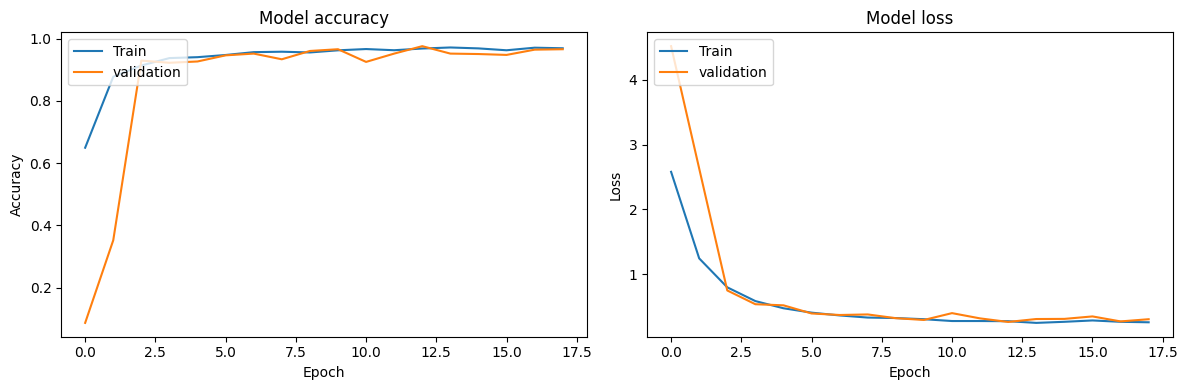

23/23 [==============================] - 0s 1ms/step


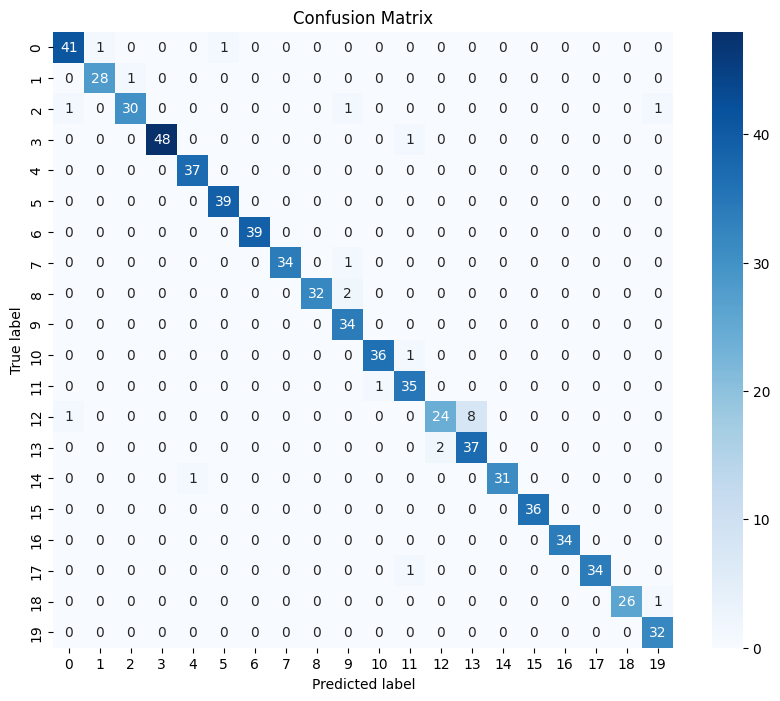

hidden accuracy: 0.9635343618513323


In [13]:

# Plot training & hiddenidation accuracy hiddenues
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

# Plot training & hiddenidation loss hiddenues
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_hidden)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_hidden, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# hidden accuracy calculation
hidden_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"hidden accuracy: {hidden_accuracy}")






In [14]:
# Save the model weights

model.save_weights("./model_weights/gesture_model.weights.h5")
model.save('./model_weights/model.keras')

In [22]:
import hls4ml
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('./model_weights/model.keras')

model.summary()

# Generate the HLS configuration from the model
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Optionally, tweak the configuration here if needed
print(config)

# Convert the Keras model to an HLS project
hls_model = hls4ml.converters.convert_from_keras_model(
    model, 
    hls_config=config, 
    output_dir='hls4ml_prj', 
    part='xczu3eg-sbva484-2-i',
    backend="Vitis"
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 118, 16)           64        
                                                                 
 batch_normalization (Batch  (None, 118, 16)           64        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 59, 16)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 57, 32)            1568      
                                                                 
 batch_normalization_1 (Bat  (None, 57, 32)            128       
 chNormalization)                                                
                                                        

In [23]:
# Use Vitis HLS to synthesize the model
# This might take several minutes
hls_model.build()




****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  **** SW Build 5069499 on May 21 2024
  **** IP Build 5075265 on Wed May 22 21:45:21 MDT 2024
  **** SharedData Build 5076995 on Wed May 22 18:29:18 MDT 2024
  **** Start of session at: Wed Aug 28 00:59:21 2024
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis_HLS/2024.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'prince' on host 'prince-ThinkPad-E14-Gen-5' (Linux_x86_64 version 6.8.0-41-generic) on Wed Aug 28 00:59:23 +08 2024
INFO: [HLS 200-10] On os Ubuntu 24.04 LTS
INFO: [HLS 200-10] In directory '/home/prince/Documents/capstone/Gesture-AI/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/home/prince/Documents/capstone/Gesture-AI/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-1510]

{'CSimResults': [['0.250977',
   '0.5',
   '0.195313',
   '0.0458984',
   '0.00390625',
   '0.00585938',
   '0',
   '0',
   '0.00195313',
   '0.0175781',
   '0.00390625',
   '0.0126953',
   '0.000976563',
   '0',
   '0.000976563',
   '0.000976563',
   '0',
   '0.00976563',
   '0',
   '0.00878906']]}